In [1]:
import numpy as np
import pickle
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import neat
from neat import Config, Population, DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation

from pureples.shared.substrate import Substrate
from pureples.shared.create_cppn import create_cppn
from pureples.es_hyperneat.es_hyperneat import ESNetwork

In [2]:
X_train = np.load('../X_train.npy')
y_train = np.load('../y_train.npy')
X_test  = np.load('../X_test.npy')
y_test  = np.load('../y_test.npy')


In [3]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
smote = SMOTE(random_state=42)
X_test, y_test = smote.fit_resample(X_test, y_test)


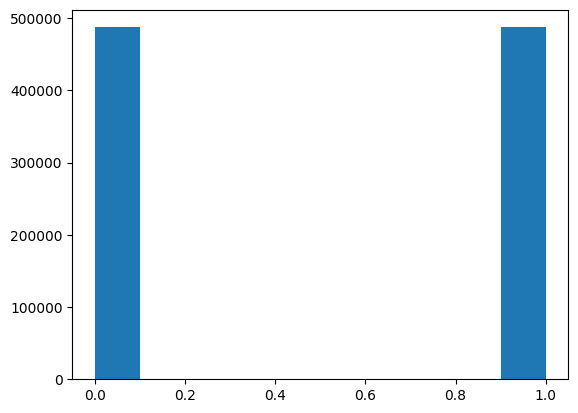

(array([121813.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 121813.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

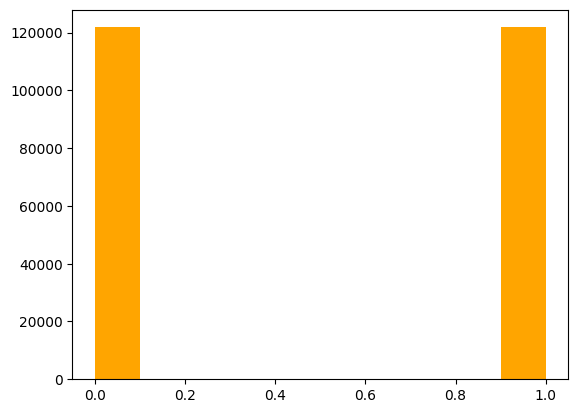

In [4]:
plt.hist(y_train)
plt.show()
plt.hist(y_test, color='orange')

In [5]:
# sample_train = 200000
# X_train = X_train[:sample_train]
# y_train = y_train[:sample_train]
# plt.hist(y_train)
# print(f"Train: {X_train.shape}, Test: {X_test.shape}")

In [6]:
i_coords = [(-1.0 + i*(2.0/3.0), 1.0) for i in range(4)]
hidden_coords = []
o_coords = [(0.0, -1.0)]  
substrate = Substrate(i_coords, o_coords, hidden_coords)

In [7]:
es_params = {
    "initial_depth":      1,
    "max_depth":          3,
    "variance_threshold": 0.03,
    "band_threshold":     0.2,
    "iteration_level":    1,
    "division_threshold": 0.3,
    "max_weight":         5.0,
    "activation":         "tanh",
}

In [8]:
def eval_genomes(genomes, config):
    for gid, genome in genomes:
        cppn = create_cppn(
            genome,
            config,
            output_activation_function=es_params["activation"]
        )
        es_net = ESNetwork(substrate, cppn, es_params)
        net    = es_net.create_phenotype_network()

        preds = [int(net.activate(x)[0] > 0.5) for x in X_train]

        genome.fitness = f1_score(y_train, preds, average='weighted')


In [9]:
config_path = "es_hyper_neat.cfg"
config = Config(DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation, config_path)

pop = Population(config)
pop.add_reporter(neat.StdOutReporter(True))
pop.add_reporter(neat.StatisticsReporter())

winner = pop.run(eval_genomes, n=20)


 ****** Running generation 0 ****** 



KeyboardInterrupt: 

In [ ]:
with open("es_hyper_model.pkl", "wb") as f:
    pickle.dump(winner, f)

In [ ]:
cppn_w = create_cppn(winner, config, output_activation_function=es_params["activation"])
es_net_w = ESNetwork(substrate, cppn_w, es_params)
net_w    = es_net_w.create_phenotype_network()

y_pred = [int(net_w.activate(x)[0] > 0.5) for x in X_test]

print("\n— Test metrics —")
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("F1-score       :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


— Test metrics —
Accuracy       : 0.9516640625
F1-score       : 0.92809465036097

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98    121813
           1       0.00      0.00      0.00      6187

    accuracy                           0.95    128000
   macro avg       0.48      0.50      0.49    128000
weighted avg       0.91      0.95      0.93    128000

Confusion matrix:
 [[121813      0]
 [  6187      0]]


/Users/nikolajsemikin/Documents/Programming/LAB-2/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nikolajsemikin/Documents/Programming/LAB-2/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nikolajsemikin/Documents/Programming/LAB-2/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 